## EE5175: Lab - 6

**Ayush Mukund Jamdar EE20B018**

### Shape from Focus

We aim to use blur as a cue to determine depth of a particular point in the scene. We will determine the depth of each pixel in the image using the Shape From Focus (SFF) algorithm. Finally, we will display the 3D structure of the scene using the calculated depth.

#### 0. Setup

In [16]:
# load modules
import numpy as np
from PIL import Image # for image loading and saving
from IPython.display import display
from matplotlib import pyplot as plt
import matplotlib.cm as cm

# Convert a grayscale png/jpg image to a numpy array
# of ints 0 to 256
def image2array(filename, colour=False):
    image = Image.open(filename)

    if colour:
        image = image.convert('L')
        image = image.resize((800, 500))
        # convert to black and white

    return np.array(image)

# Save a 2D numpy array as an image in jpg/png
def saveArrAsImage(image_array, filepath, file_format):
    image = Image.fromarray(image_array)
    # image.show()
    image.save(filepath, file_format)
    return

# Display a 2D numpy array as an image in the notebook
def displayImageArray(image_array):
    image = Image.fromarray(image_array)
    display(image)

def display3DImageArray(image_mat, size=(10, 8)):
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(projection='3d')
    X, Y = np.meshgrid(np.arange(len(image_mat)), np.arange(len(image_mat)))
    surface = ax.plot_surface(X, Y, image_mat, cmap=cm.jet, linewidth=0)
    plt.title("Depth Map")
    fig.colorbar(surface)
    plt.show()

In [17]:
from scipy.io import loadmat

images = loadmat("stack.mat")
# type(images) = dict

The loaded `images` are in a dictionary with keys `framexxx` for 100 frames. These are the different images.

In [18]:
frame_names = ['frame' + "{:03}".format(i) for i in range (1, 101)]

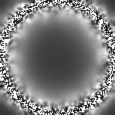

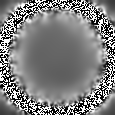

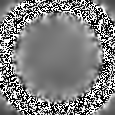

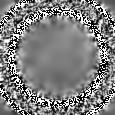

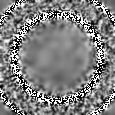

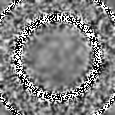

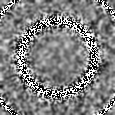

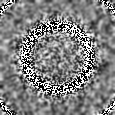

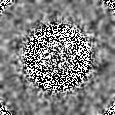

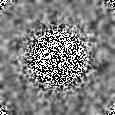

In [19]:
# display every tenth image
for i in range(0, len(frame_names), 10):
    displayImageArray(images[frame_names[i]])

#### 1. Calculate SML

We calculate the Sum-Modified Laplacian (SML) for each of these frames.

$\text{SML}(X) = \Sigma_{Z \in W(X)} |f_{XX}(Z)| + |f_{YY}(Z)|$

$$f_{XX}(\cdot) =
\left[\begin{matrix}
0 & 0 & 0 \\
1 & -2 & 1 \\
0 & 0 & 0 \\
\end{matrix} \right]
$$

$$f_{YY}(\cdot) =
\left[\begin{matrix}
0 & 1 & 0 \\
0 & -2 & 0 \\
0 & 1 & 0 \\
\end{matrix} \right]
$$

The same, for the $I^{th}$ frame, can be written as -
$$
SML_{I}(x, y) = \Sigma_{i=-q}^{i=q}\Sigma_{j=-q}^{j=q}ML_{I} (x+i, y+j)
$$


The following two functions are critical.

1. `get_ml_measure`
- for each frame we find an ML measure matrix.
- we pad the frame with $q+1$ zeros so that the ML Measure matrix is of dimensions $(N+q) \times (N+q)$. 
- this extra dimension will be useful when calculating SML.

2. `get_sml_measure`
- utilizes the ML Measure matrix and simply adds up ML measures for points falling in the `q` window.

In [26]:
def get_ml_measure(image_mat, q):
    """
    input:
    image_mat: one frame for which ML is calculated
    q: SML window size

    output:
    ml_measure: (N+q x N+q) matrix with ML measures

    """

    # define Laplacian double derivative matrices
    fxx = np.array(([0, 0, 0], [1, -2, 1], [0, 0, 0]))
    fyy = np.array(([0, 1, 0], [0, -2, 0], [0, 1, 0]))

    # zero pad image:
    # since fxx fyy are 3x3, only one extra layer of zeros required
    # over the q padding
    image_mat_padded = np.pad(image_mat, (q+1, q+1), "constant", constant_values=(0, 0))

    N = image_mat.shape[0]

    ml_measure_mat = np.zeros((N+2*q, N+2*q))

    for i in range(0, N+2*q-2):
        for j in range(0, N+2*q-2):     
            ml_fxx = np.sum(fxx * image_mat_padded[i:i+3, j:j+3])
            ml_fyy = np.sum(fyy * image_mat_padded[i:i+3, j:j+3])
            ml_measure_mat[i, j] = np.abs(ml_fxx) + np.abs(ml_fyy)

    return ml_measure_mat


def get_sml_measure(ml_frame, q):
    """
    input:
    ml_frame:
    - ML Measure of that frame calculated after q padding (N+q x N+q)
    q: window size

    output: 
    - a matrix of SML calculated for each pixel values
    - for that frame
    """

    sml_mat = np.zeros((ml_frame.shape[0]-2*q, ml_frame.shape[1]-2*q))

    for x in range(sml_mat.shape[0]):
        for y in range(sml_mat.shape[1]):
            for i in range(-q, q+1):
                for j in range(-q, q+1):
                    sml_mat[x, y] += ml_frame[x+i+q, y+j+q]

    return sml_mat



#### 2. Gaussian Interpolation

Now that we have the focus measure, we will find the depth for each pixel using Gaussian Interpolation.

Procedure -
1. For each pixel, find the $d_m$ distance corresponding to maximum focal measure $f_m$.
2. Hence find $d_{m-1}$ and $d_{m+1}$.
3. Using these three points and the Gaussian Interpolation expression discussed in class, arrive at $\bar{d}$

In [21]:
def get_actual_depth(i, j, frame_names, sml_frames, del_d):
    """
    inputs
    i, j = pixel indices from the images
    sml_frames = dict of sml measure of all images from the stack

    output
    actual_depth = d_bar calculated using Gaussian interpolation
    """

    # m is the index corresponding to maximum SML Measure
    m = np.argmax([(sml_frames[frame_names[n]])[i, j] for n in range(len(sml_frames))])

    N = len(frame_names)  # number of frames

    fm = (sml_frames[frame_names[m]])[i, j]
    fmp1 = (sml_frames[frame_names[m+1 // N]])[i, j]  # fm plus 1
    fmm1 = (sml_frames[frame_names[m-1]])[i, j]  # fm minus 1

    dm = m * del_d
    dmp1 = (m+1) * del_d
    dmm1 = (m-1) * del_d

    Nr = (np.log(fm) - np.log(fmm1)) * (dmp1**2 - dm**2) - (np.log(fm) - np.log(fmp1)) * (dmm1**2 - dm**2)
    Dr = 2 * del_d * (2*np.log(fm) - np.log(fmm1) - np.log(fmp1))
    d_bar = Nr / Dr

    return d_bar

#### 3. Assignment

Now we perform the complete simulation for three values of SML Window $q = 0, 1, 2$.

Case: q = 0


C:\Users\USER\AppData\Local\Temp\ipykernel_24884\1101632444.py:24: RuntimeWarning: divide by zero encountered in log
  Nr = (np.log(fm) - np.log(fmm1)) * (dmp1**2 - dm**2) - (np.log(fm) - np.log(fmp1)) * (dmm1**2 - dm**2)
C:\Users\USER\AppData\Local\Temp\ipykernel_24884\1101632444.py:24: RuntimeWarning: invalid value encountered in scalar subtract
  Nr = (np.log(fm) - np.log(fmm1)) * (dmp1**2 - dm**2) - (np.log(fm) - np.log(fmp1)) * (dmm1**2 - dm**2)
C:\Users\USER\AppData\Local\Temp\ipykernel_24884\1101632444.py:25: RuntimeWarning: divide by zero encountered in log
  Dr = 2 * del_d * (2*np.log(fm) - np.log(fmm1) - np.log(fmp1))
C:\Users\USER\AppData\Local\Temp\ipykernel_24884\1101632444.py:25: RuntimeWarning: invalid value encountered in scalar subtract
  Dr = 2 * del_d * (2*np.log(fm) - np.log(fmm1) - np.log(fmp1))


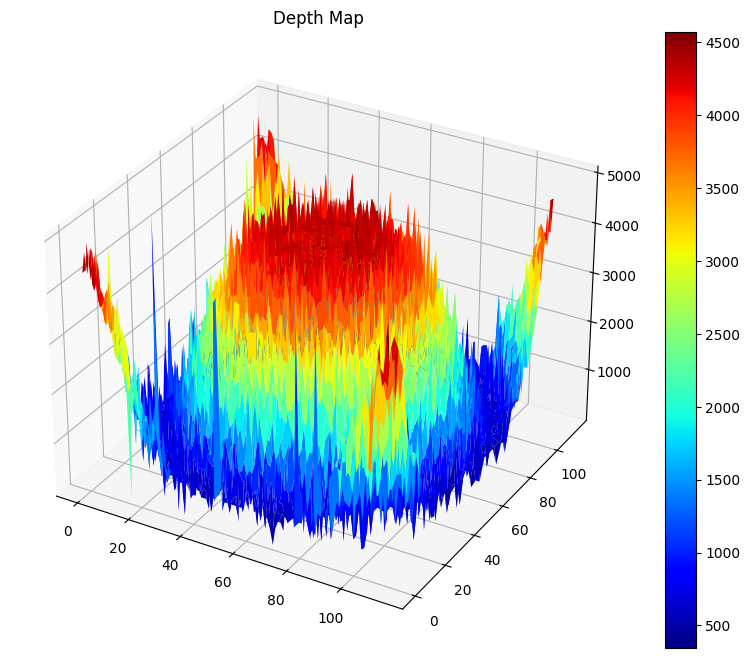

Case: q = 1


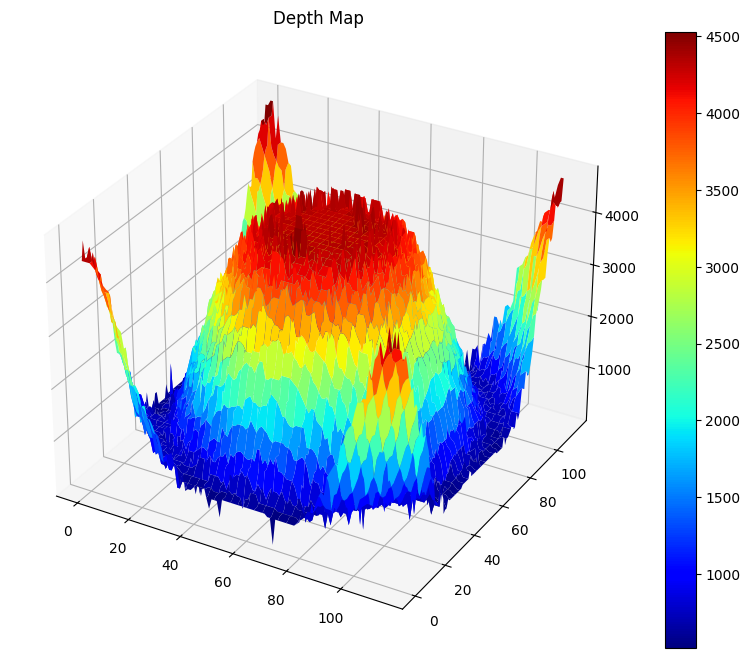

Case: q = 2


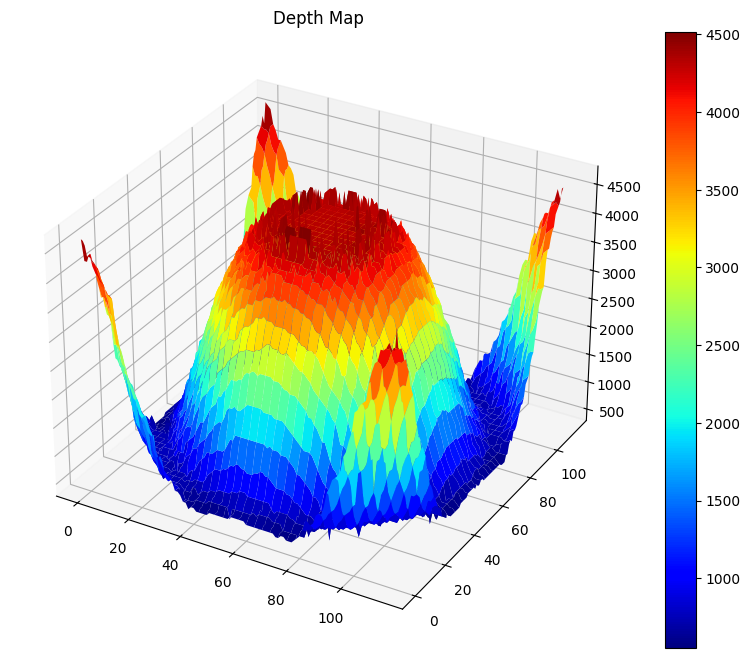

In [28]:
del_d = 50.50
qs = [0, 1, 2]

for q in qs:
    print("Case: q =", q)

    sml_frames = {}

    for frame in frame_names:
        ml_frame = get_ml_measure(images[frame], q)
        sml_frames[frame] = get_sml_measure(ml_frame, q)

    actual_depth_pixelwise = np.zeros_like(images[frame_names[0]]).astype(float)
    # here we create a matrix that stores d_bar actual depth
    # corresponding to each pixel in the image

    for i in range(actual_depth_pixelwise.shape[0]):
        for j in range(actual_depth_pixelwise.shape[1]):
            actual_depth_pixelwise[i, j] = get_actual_depth(i, j, frame_names, sml_frames, del_d)

    # display this depth map as a 3D image
    display3DImageArray(actual_depth_pixelwise)


#### Conclusion
- Note that the above 3D plots indicate a depth map. High values imply that the point was 'deeper' inside the image. 
- Thus, the points at the center are farthest.
- The corners seem to have high depth values because when we zero padded, that induced a sharp gradient there in both directions. This would mean that the corner depth measures are unreliable.
- Finally, we observe that the depth map improves with `q`. The reason is clear - SML is a better focus measure that ML as it incorporates multiple focus measures from proximity. 